In [14]:
# Importação do grafo
from networkx import nx_agraph
from graphviz import Source

# Carregar o grafo usando NetworkX
graph = nx_agraph.read_dot('./graphs/graph3.dot')

# Converter o grafo para o formato DOT
graph_dot = nx_agraph.to_agraph(graph)

# Imprime na tela
source = Source(graph_dot.to_string())
# source
source.view()

'Source.gv.pdf'

## Algoritmo de Prim
Implemente o algoritmo de Prim, para calcular a árvore geradora mínima
de um grafo dado. Utilize um heap binário como lista de prioridade.
Utilize o algoritmo da Seção 21.2 do livro do Cormen, 4a edição, como
referência.

0 == 10 - 1
QUEUE IN: ('a', 'b') with weight 2
QUEUE IN: ('a', 'e') with weight 4
TREE IN: ('a', 'b') with weight 2
1 == 10 - 1
QUEUE IN: ('b', 'c') with weight 5
QUEUE IN: ('b', 'h') with weight 4
TREE IN: ('a', 'e') with weight 4
2 == 10 - 1
QUEUE IN: ('e', 'd') with weight 3
TREE IN: ('e', 'd') with weight 3
3 == 10 - 1
QUEUE IN: ('d', 'c') with weight 1
TREE IN: ('d', 'c') with weight 1
4 == 10 - 1
QUEUE IN: ('c', 'f') with weight 7
TREE IN: ('b', 'h') with weight 4
5 == 10 - 1
QUEUE IN: ('h', 'g') with weight 6
QUEUE IN: ('h', 'i') with weight 3
TREE IN: ('h', 'i') with weight 3
6 == 10 - 1
QUEUE IN: ('i', 'j') with weight 5
6 == 10 - 1
TREE IN: ('i', 'j') with weight 5
7 == 10 - 1
QUEUE IN: ('j', 'f') with weight 2
TREE IN: ('j', 'f') with weight 2
8 == 10 - 1
QUEUE IN: ('f', 'g') with weight 2
TREE IN: ('f', 'g') with weight 2


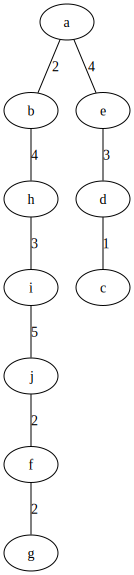

In [18]:
import heapq
from networkx import Graph, has_path

queue = []
result_tree = Graph()
result_tree.add_node(list(graph.nodes)[0])
added_nodes = set()

def edge_already_used(edge):
    return result_tree.has_node(edge[0]) and result_tree.has_node(edge[1])

def edge_already_added(edge):
    return queue.count((int(edge[2]["label"]), edge[:2])) > 0

def forms_cycle(edge):
    # Check if adding the edge creates a cycle using a simple path check
    if result_tree.has_node(edge[0]) and result_tree.has_node(edge[1]):
        return has_path(result_tree, edge[0], edge[1])
    return False

def add_node_to_queue(node):
    for edge in graph.edges(node, data=True):
        if not edge_already_used(edge) and not edge_already_added(edge):
            weight = int(edge[2]["label"])
            heapq.heappush(queue, (weight, edge[:2]))
            print(f"QUEUE IN: {edge[:2]} with weight {weight}")
    added_nodes.add(node)

while len(result_tree.edges) != len(graph.nodes) - 1:
    print(f"{len(result_tree.edges)} == {len(graph.nodes)} - 1")
    
    node_to_add_to_queue = set(result_tree.nodes) - added_nodes
    if node_to_add_to_queue:
        add_node_to_queue(node_to_add_to_queue.pop())

    if queue:
        weight, edge = heapq.heappop(queue)
        if not forms_cycle(edge):
            result_tree.add_edge(*edge, label=weight)
            print(f"TREE IN: {edge} with weight {weight}")


# Imprime na tela
result_tree_dot = nx_agraph.to_agraph(result_tree)  
source = Source(result_tree_dot.to_string())
source

## Algoritmo de Bellman-Ford
Implemente o algoritmo de Bellman-Ford, que calcula os caminhos mínimos de um vértice para todos os vértices de um grafo. Utilize o algoritmo
da Seção 22.1 do livro do Cormen, 4a edição, como referência.

## Algoritmo de Floyd-Warshall
Implemente o algoritmo de Floyd-Warshall, que calcula os caminhos mínimos de todos os vértices para todos os vértices de um grafo. Utilize o
algoritmo da Seção 23.2 do livro do Cormen, 4a edição, como referência.